# Instacart Market Basket Analysis

The goal is to predict which products will be in a user's next order. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users.

For each user, 4 and 100 of their orders are given, with the sequence of products purchased in each order.

<img src='instacart_product_wordcloud.png'>

## Import Libraries

In [1]:
%%capture
! pip install wordcloud

# data processing
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import pickle
from sklearn.preprocessing import LabelBinarizer
from random import sample

# data visualization
import seaborn as sns
from wordcloud import WordCloud,ImageColorGenerator

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, precision_score, recall_score, classification_report

from collections import OrderedDict

%matplotlib inline
sns.set(context='notebook', style='whitegrid')
np.set_printoptions(suppress=True) 

## Load in the Data

In [2]:
path = '/Users/elizabethnaameh/Downloads/instacart_db/'

df_orders = pd.read_csv(path + 'orders.csv')
df_order_products_prior = pd.read_csv(path + 'order_products__prior.csv')
df_order_products_train = pd.read_csv(path + 'order_products__train.csv')
df_aisles = pd.read_csv(path + 'aisles.csv')
df_departments = pd.read_csv(path + 'departments.csv')
df_products = pd.read_csv(path + 'products.csv')

## Explore the Data

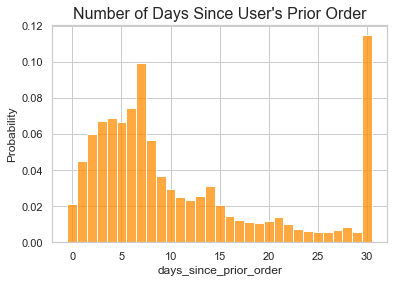

In [3]:
sns.histplot(data = df_orders, x='days_since_prior_order', binwidth=1, discrete=True, stat = 'probability', color='darkorange').set_title('Number of Days Since User\'s Prior Order', fontdict ={'fontsize':16});

We can see from the plot above that users tend to make orders exactly one week apart, with over half of orders placed within a week of the prior order.

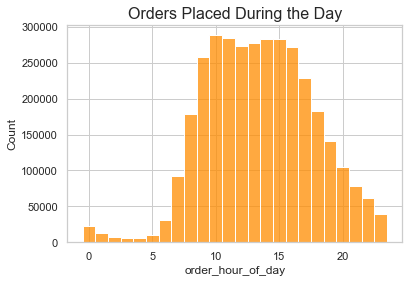

In [4]:
sns.histplot(data = df_orders, x='order_hour_of_day', binwidth=1, discrete=True, color='darkorange').set_title('Orders Placed During the Day', fontdict ={'fontsize':16});

The busiest period for orders is between 10am and 4pm. 

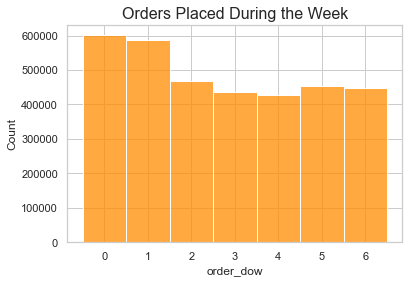

In [5]:
sns.histplot(data = df_orders, x='order_dow', discrete=True, color='darkorange').set_title('Orders Placed During the Week', fontdict ={'fontsize':16});

The busiest days of the week for orders are Saturday and Sunday, coded as 0 and 1, respectively.

We'll want to combine the order/product information with user information, so we'll go ahead and merge the `order_products` tables with the `orders` table.

In [6]:
df_order_products_train = df_order_products_train.merge(df_orders.drop('eval_set', axis=1), on='order_id')
df_order_products_prior = df_order_products_prior.merge(df_orders.drop('eval_set', axis=1), on='order_id')

df = df_order_products_prior.merge(df_products, on='product_id')
df = df.merge(df_aisles, on = 'aisle_id').merge(df_departments, on ='department_id')
df.drop(labels=['aisle_id', 'department_id'], inplace=True, axis=1)

df.head(3)

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle,department
0,2,33120,1,1,202279,3,5,9,8.0,Organic Egg Whites,eggs,dairy eggs
1,26,33120,5,0,153404,2,0,16,7.0,Organic Egg Whites,eggs,dairy eggs
2,120,33120,13,0,23750,11,6,8,10.0,Organic Egg Whites,eggs,dairy eggs


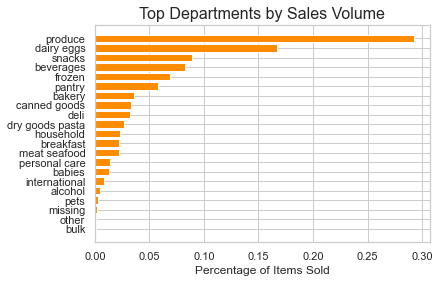

In [7]:
# visualize top departments by sales volume
department_freq = df.department.value_counts(normalize=True, ascending=True)
department_freq = pd.DataFrame(department_freq)

x, y = department_freq.index, department_freq.department

plt.barh(x, y, color = 'darkorange')
plt.title('Top Departments by Sales Volume', fontdict ={'fontsize':16})
plt.xlabel('Percentage of Items Sold')
plt.show()

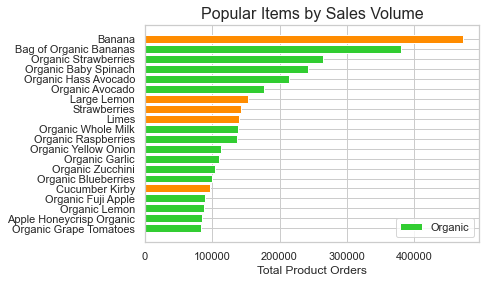

In [8]:
# visualize top products by sales volume
top_20_products = df_order_products_prior.groupby(['product_id'], as_index=False) \
                                         .agg({'order_id':'count'}) \
                                         .rename(columns={'order_id':'product_total_orders'}) \
                                         .sort_values(by='product_total_orders', ascending=False) \
                                         .head(20)
                
top_20_products = top_20_products.merge(df_products.drop(labels=['aisle_id', 'department_id'], axis=1), on='product_id') \
                                 .sort_values(by='product_total_orders', ascending=True)
    
x, y = top_20_products.product_name, top_20_products.product_total_orders

cc = ['limegreen' if ('Organic' in val) else 'darkorange' for val in x]

plt.barh(x, y, color = cc)
plt.title('Popular Items by Sales Volume', fontdict ={'fontsize':16})
plt.xlabel('Total Product Orders')
plt.legend(['Organic'])
plt.show()

In [9]:
# #making of word cloud from Product name column
# wordcloud_df = df_order_products_prior.sample(1000000)\
#                                       .merge(df_products, on='product_id')

# wordcloud_list = list(wordcloud_df['product_name'])
# wordcloud_list = [words for segments in wordcloud_list for words in segments.split()]

# text = " ".join(topic for topic in wordcloud_list)

# # Create and generate a word cloud image:
# wordcloud = WordCloud(background_color="white", width=800, height=400).generate(text)

# plt.axis("off")
# plt.tight_layout(pad=5)
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.show()

# Machine Learning

Next we'll set up the classification problem. For the instacart challenge, the given task is to predict which products will show up again in a user's next order based on their entire product order history. We can worry about aggregating to the cart level later, but understand for now that this problem will require us to make **individual binary predictions for every unique user-product combination** in the order history, where the target is 1 or 0 for if that product shows up in the user's next/most current order.    

With that in mind, we'll create a **`df_X` as our ML-formatted dataframe**, with a user-product aggregated version of the `order_products_prior` data. We'll go ahead and count the total # of times the user has ordered each product as our first feature since we're already doing a user-product aggregation.

## Feature #1: Percent of user's prior purchases that include the product

In [10]:
#calculate the number of user's orders that include each product
df_user_product = (df_order_products_prior.groupby(['product_id','user_id'],as_index=False)
                                          .agg({'order_id':'count'}) 
                                          .rename(columns={'order_id':'user_product_total_orders'}))

#calculate total number of orders placed by user
df_user_total_orders = (df_order_products_prior.groupby(['user_id'],as_index=False)['order_id'].nunique()
                                               .rename(columns={'order_id':'user_total_orders'}))

df_user_product = df_user_product.merge(df_user_total_orders, on='user_id')

df_user_product['user_product_pct_orders_with_product'] = df_user_product['user_product_total_orders'] / df_user_product['user_total_orders']
#df_user_product.drop(columns=['user_product_total_orders', 'user_total_orders'], inplace=True)

# Ensure our data only includes users represented in our target 
target_ids = df_order_products_train['user_id'].unique() 
df_X = df_user_product[df_user_product['user_id'].isin(target_ids)]

df_X.head(3)

,product_id,user_id,user_product_total_orders,user_total_orders,user_product_pct_orders_with_product
0,1,138,2,32,0.06250
1,907,138,2,32,0.06250
2,1000,138,1,32,0.03125


## Generate Target Labels 

Next we need to get our labels. To do this, we'll group our current cart data (`order_products_train`) by user and collect a set of the items in that cart. Then we can merge with `df_X` and iterate through the rows to get labels for whether each product occurs in the latest cart.  

In [11]:
train_carts = (df_order_products_train.groupby('user_id',as_index=False)
                                      .agg({'product_id':(lambda x: set(x))})
                                      .rename(columns={'product_id':'latest_cart'}))

df_X = df_X.merge(train_carts, on='user_id')
df_X['in_cart'] = (df_X.apply(lambda row: row['product_id'] in row['latest_cart'], axis=1).astype(int))

df_X = df_X.drop(labels=['user_total_orders'], axis=1)

Nice, now we actually have a dataset that's shaped as a binary classification problem: **`in_cart` is our target**, and **each observation is a unique user-product combination** based on the entire order history for users in our current cart data.

## Baselining

We can see we are dealing with a highly imbalanced dataset.

0    0.9022
1    0.0978
Name: in_cart, dtype: float64


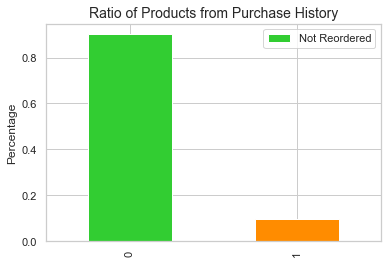

In [12]:
target_pcts = df_X.in_cart.value_counts(normalize=True) 
print(target_pcts)

target_pcts.plot(kind='bar', color=['limegreen', 'darkorange'], ylabel='Percentage');
plt.legend(['Not Reordered', 'Reordered'], loc="upper right");
plt.title('Ratio of Products from Purchase History', fontdict = {'fontsize' : 14});

Now that we have a feel for our target, we'll start looking for feature-target relationships. Since we'll do this repeatedly on a sample of the data as we build out features, let's write another utility function that generates a seaborn pairplot matrix colored by the target value.  

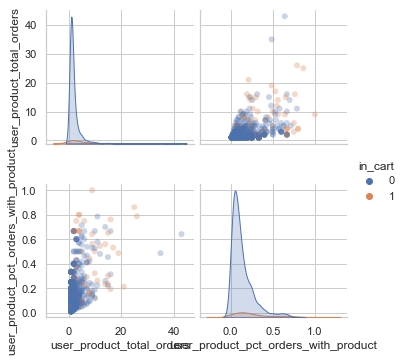

In [13]:
def plot_features(df, sample_size=1000):
    
    sample = (df.drop(['product_id','user_id','latest_cart'],axis=1)
                .sample(sample_size, random_state=44)) 
    sns.pairplot(sample,hue='in_cart', plot_kws=dict(alpha=.3, edgecolor='none'))

plot_features(df_X)

It's a bit hard to see, but in `the user_product_total_orders` plot there's evidence that higher values are associated with higher likelihood of a positive target (this is intuitive). Don't be deceived by the longer right tail for the negative target samples, this is likely an artifact of the class imbalance.

Right now this looks like a very meagre machine learning problem! We only have 1 usable feature and it doesn't look like a strong one - the total orders placed for each user-product combination. Let's use a simple logistic model with this feature as a baseline, and see how much predictive power we can add to this baseline by **building out our feature set with feature engineering**.

For this problem, we want to be **extra careful about validation/testing**. If we do a simple train/test split, we'll end up with users that occur in both the training and test data and run the risk of overfitting to the tendencies of specific users. Instead, we'll manually sample 20% of the users to put into our test set, and use the remaining 80% of users for the training data. Since we'll be doing this several times as we build out feature sets, we'll encapsulate the sampling process in a `get_user_split_data` function that mimics the behavior of sklearn's `train_test_split`. 

In [14]:
def get_user_split_data(df, val_size = 0.2, test_size=.2, seed=42): # custom train-validate-test split function

    rs = np.random.RandomState(seed)
    
    total_users = df['user_id'].unique() 
    test_users = rs.choice(total_users, 
                           size=int(total_users.shape[0] * test_size), 
                           replace=False)
    non_test_users = np.array(list(set(total_users) - set(test_users)))
    val_users = rs.choice(non_test_users, 
                           size=int(non_test_users.shape[0] * val_size), 
                           replace=False)
    non_test_users = np.array(list(set(non_test_users) - set(val_users)))

    df_tr = df[df['user_id'].isin(non_test_users)]
    df_val = df[df['user_id'].isin(val_users)]
    df_te = df[df['user_id'].isin(test_users)] 

    y_tr, y_val, y_te = df_tr['in_cart'], df_val['in_cart'], df_te['in_cart']
    X_tr = df_tr.drop(['product_id','user_id','latest_cart','in_cart'],axis=1) 
    X_val = df_val.drop(['product_id','user_id','latest_cart','in_cart'],axis=1)
    X_te = df_te.drop(['product_id','user_id','latest_cart','in_cart'],axis=1)

    return X_tr, X_val, X_te, y_tr, y_val, y_te


def run_logreg(X_tr, X_te, y_tr, y_te): #custom logistic regression function
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_tr)
    X_test_scaled = scaler.transform(X_te)
    
    lr = LogisticRegression(class_weight='balanced', C=1)
    lr.fit(X_train_scaled, y_tr)
    y_preds = lr.predict(X_test_scaled)
    print('F1 Score:', round(f1_score(y_preds, y_te), 5), '\n')

    # Print confusion matrix for logistic regression
    logit_confusion = confusion_matrix(y_te, y_preds, normalize='all')
    print('Confusion Matrix: \n', logit_confusion, '\n')

    # Precision = TP / (TP + FP)
    # Recall = TP/P = True positive rate
    # false positive rate = FP / true negatives = FP / (FP + TN) 
    fpr, tpr, thresholds = roc_curve(y_te, lr.predict_proba(X_test_scaled)[:,1])

    plt.plot(fpr, tpr,lw=2)
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve');
    print("ROC AUC score = ", round(roc_auc_score(y_te, lr.predict_proba(X_test_scaled)[:,1]), 5))
    
    return X_train_scaled, X_test_scaled, lr

With this splitting function in hand and our logistic regression model generator, we're ready to train and evaluate our simple baseline model.

F1 Score: 0.3479 

Confusion Matrix: 
 [[0.72123004 0.18142302]
 [0.03864382 0.05870312]] 

ROC AUC score =  0.77876


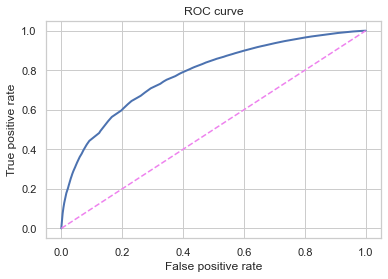

In [15]:
X_tr, X_val, X_te, y_tr, y_val, y_te = get_user_split_data(df_X)
X_train_scaled, X_val_scaled, lr = run_logreg(X_tr, X_val, y_tr, y_val)

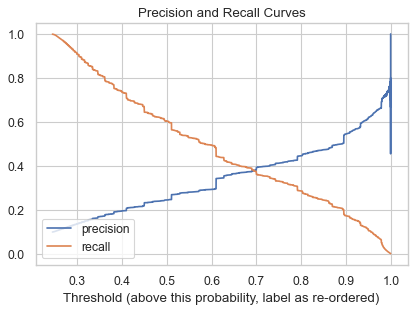

In [16]:
# We can also use the probabilities to make a curve showing us how recall and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, lr.predict_proba(X_val_scaled)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as re-ordered)');
plt.title('Precision and Recall Curves');
    
    
def find_best_thresh(model, X, y):
    
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(y, lr.predict_proba(X)[:,1] )

    # identify best threshold
    idx = np.argmin(np.abs(precision_curve - recall_curve))
    best_threshold = threshold_curve[idx]
    
    return best_threshold


best_thresh = find_best_thresh(lr, X_val_scaled, y_val)


In [17]:
best_thresh

0.6944657275704271

Threshold of 0.694:
Precision: 0.3791,   Recall: 0.3767
F1 score:  0.3778946847131695


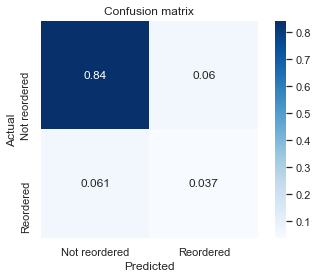

In [18]:
def find_f1(model, X, y, thresh):
    y_preds = (lr.predict_proba(X)[:,1] > thresh)
    print(f"Threshold of {thresh:.3f}:")
    print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y, y_preds), 
                                                         recall_score(y, y_preds)))
    f1 =  f1_score(y_preds, y)
    print('F1 score: ', round(f1, 3))
    
    cart_confusion = confusion_matrix(y, y_preds, normalize='all')
    sns.heatmap(cart_confusion, cmap=plt.cm.Blues, annot=True, square=True,
               xticklabels=['Not reordered', 'Reordered'],
               yticklabels=['Not reordered', 'Reordered'])

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion matrix');

    
#4
find_f1(lr, X_val_scaled, y_val, best_thresh)

## Feature #3: # Orders since product was last ordered

In [19]:
df_X_backup = df_X.copy()

df_latest_order = df_order_products_prior.groupby(['user_id'], as_index=False)\
                                         .agg({'order_number': 'max'})

df_orders_since_last_purchase = df_order_products_prior.groupby(['user_id', 'product_id'], as_index=False)\
                                                               .agg({'order_number': 'max'})\
                                                               .merge(df_latest_order, on='user_id')

df_orders_since_last_purchase['orders_since_purchased'] = df_orders_since_last_purchase['order_number_y'] - df_orders_since_last_purchase['order_number_x']

df_X = df_X.merge(df_orders_since_last_purchase.drop(labels=['order_number_x', 'order_number_y'], axis=1), on=['user_id', 'product_id'])

df_X.head(3)

,product_id,user_id,user_product_total_orders,user_product_pct_orders_with_product,latest_cart,in_cart,orders_since_purchased
0,1,138,2,0.06250,{42475},0,2
1,907,138,2,0.06250,{42475},0,22
2,1000,138,1,0.03125,{42475},0,23


F1 Score: 0.34648 

Confusion Matrix: 
 [[0.67030225 0.23235081]
 [0.02826118 0.06908576]] 

ROC AUC score =  0.80745


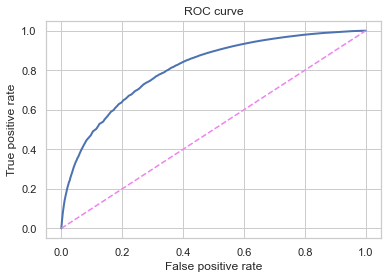

In [20]:
X_tr, X_val, X_te, y_tr, y_val, y_te = get_user_split_data(df_X)
X_train_scaled, X_val_scaled, lr = run_logreg(X_tr, X_val, y_tr, y_val)

Threshold of 0.696:
Precision: 0.3953,   Recall: 0.3953
F1 score:  0.395271925061607


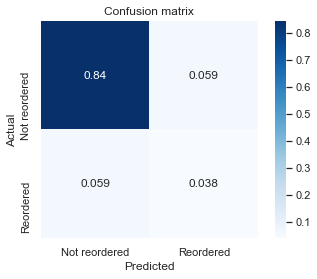

In [21]:
best_thresh = find_best_thresh(lr, X_val_scaled, y_val)
find_f1(lr, X_val_scaled, y_val, best_thresh)

## Features #4-5: Product is_Organic and user's history pct_Organic

In [22]:
#classify each product as organic or not
df_products['is_organic'] = (df_products.apply(lambda row: 'Organic' in row['product_name'], axis=1).astype(int))

#calculate percentage of organic from total sales volume
df_order_products_prior = df_order_products_prior.merge(df_products.drop(labels=['aisle_id', 'department_id', 'product_name'], axis=1), on='product_id')
df_order_products_prior['is_organic'].mean()

#calculate each user's percentage of organic from all products purchased
df_organic = df_order_products_prior.groupby(['user_id'], as_index=False)\
                       .agg({'product_id':'count', 'is_organic': 'sum'})\
                       .rename(columns={'product_id':'product_count', 'is_organic': 'organic_count'})

df_organic['pct_organic'] = df_organic['organic_count']/df_organic['product_count']

#merge into feature set whether each product is organic and a user's propensity to buy organic
df_X = df_X.merge(df_organic.drop(labels=['product_count', 'organic_count'], axis=1), on='user_id')
df_X = df_X.merge(df_products.drop(labels=['aisle_id', 'department_id', 'product_name'], axis=1), on='product_id')
df_X.head(3)

,product_id,user_id,user_product_total_orders,user_product_pct_orders_with_product,latest_cart,in_cart,orders_since_purchased,pct_organic,is_organic
0,1,138,2,0.062500,{42475},0,2,0.108108,0
1,1,709,1,0.200000,"{45444, 32005, 26893, 8859, 28577, 48036, 1027...",0,3,0.020833,0
2,1,777,1,0.038462,"{43352, 6184, 16797}",0,10,0.168142,0


F1 Score: 0.34905 

Confusion Matrix: 
 [[0.67026279 0.23194534]
 [0.02807817 0.0697137 ]] 

ROC AUC score =  0.80858


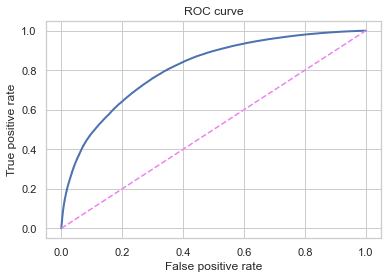

In [24]:
X_tr, X_val, X_te, y_tr, y_val, y_te = get_user_split_data(df_X)
X_train_scaled, X_val_scaled, lr = run_logreg(X_tr, X_val, y_tr, y_val)

Threshold of 0.700:
Precision: 0.3969,   Recall: 0.3969
F1 score:  0.3968819213862138


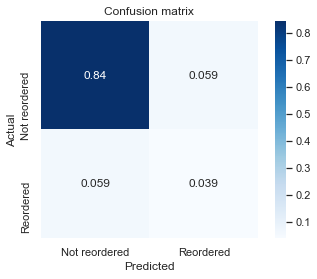

In [26]:
best_thresh = find_best_thresh(lr, X_val_scaled, y_val)
find_f1(lr, X_val_scaled, y_val, best_thresh)

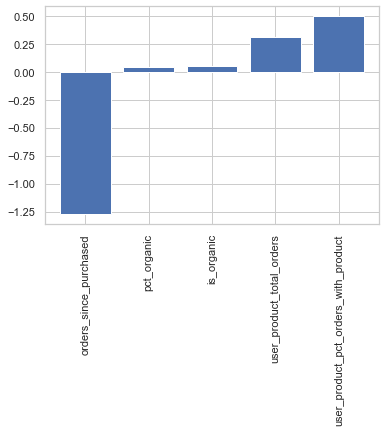

In [27]:
df_features = df_X.columns.drop(['product_id','user_id','latest_cart', 'in_cart']) 

D = dict(zip(df_features, lr.coef_.T.flatten()))
D = {k: v for k, v in sorted(D.items(), key=lambda item: item[1])}
#plt.figure(figsize=(15, 10))
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.xticks(rotation=90);

## Feature #6: Difference between Typical Hour-of-Day Purchase and current HOD

We haven't used the data on order time / day of week at all yet. We could use this to measure the typical times 
products tend to be ordered (both generically and at the user-product level), and quantify the difference
between the time of the latest order and these typical times to pick up new signal around ordering patterns.

In [28]:
# average hour of day users ordered a specific product historically
df_products_avg_hod = df_order_products_prior.groupby(['user_id', 'product_id'], as_index=False)\
                                             .agg({'order_hour_of_day': 'mean'})\
                                             .rename(columns={'order_hour_of_day':'avg_hod_product'})

# calculate the delta_hod between current order (train) and average order for same product for user.
df_order_products_train = df_order_products_train.merge(df_products_avg_hod, on = ['user_id', 'product_id'])

curr_cart_time = df_order_products_train.groupby('user_id', as_index=False)\
                                        .agg({'order_hour_of_day':'mean'})\
                                        .rename(columns={'order_hour_of_day':'curr_cart_hod'})

df_delta_hod = df_products_avg_hod.merge(curr_cart_time, on='user_id')

time_diff = abs(df_delta_hod['avg_hod_product'] - df_delta_hod['curr_cart_hod'])
twelve = pd.Series(np.full(shape=time_diff.size,fill_value=12,dtype=int))

df_delta_hod['product_hod_delta'] = pd.concat([time_diff, twelve], axis=1).min(axis=1)

KeyError: "['avg_hod'] not found in axis"

In [29]:
df_X = df_X.merge(df_delta_hod.drop(labels=['avg_hod_product', 'curr_cart_hod'], axis=1), on=['user_id', 'product_id'])

df_X

,product_id,user_id,user_product_total_orders,user_product_pct_orders_with_product,latest_cart,in_cart,orders_since_purchased,pct_organic,is_organic,product_hod_delta
0,1,138,2,0.062500,{42475},0,2,0.108108,0,2.000000
1,1,709,1,0.200000,"{45444, 32005, 26893, 8859, 28577, 48036, 1027...",0,3,0.020833,0,1.000000
2,1,777,1,0.038462,"{43352, 6184, 16797}",0,10,0.168142,0,5.000000
3,1,1052,2,0.100000,{17207},0,5,0.166667,0,2.000000
4,1,1494,3,0.230769,{44560},0,4,0.050633,0,0.666667
...,...,...,...,...,...,...,...,...,...,...
8205562,10225,182791,1,0.200000,"{27204, 45673, 9034, 17807, 21903, 17429}",0,0,0.230769,0,2.000000
8205563,18003,185846,1,0.166667,"{43209, 23082, 7535, 41777, 18003, 39764}",1,0,0.000000,0,9.000000
8205564,16980,160509,8,0.347826,"{35561, 16980}",1,1,0.333333,0,4.000000
8205565,37902,19935,3,0.750000,"{34887, 3177, 39059, 24852, 30709, 39993, 41468}",0,1,0.090909,0,7.000000


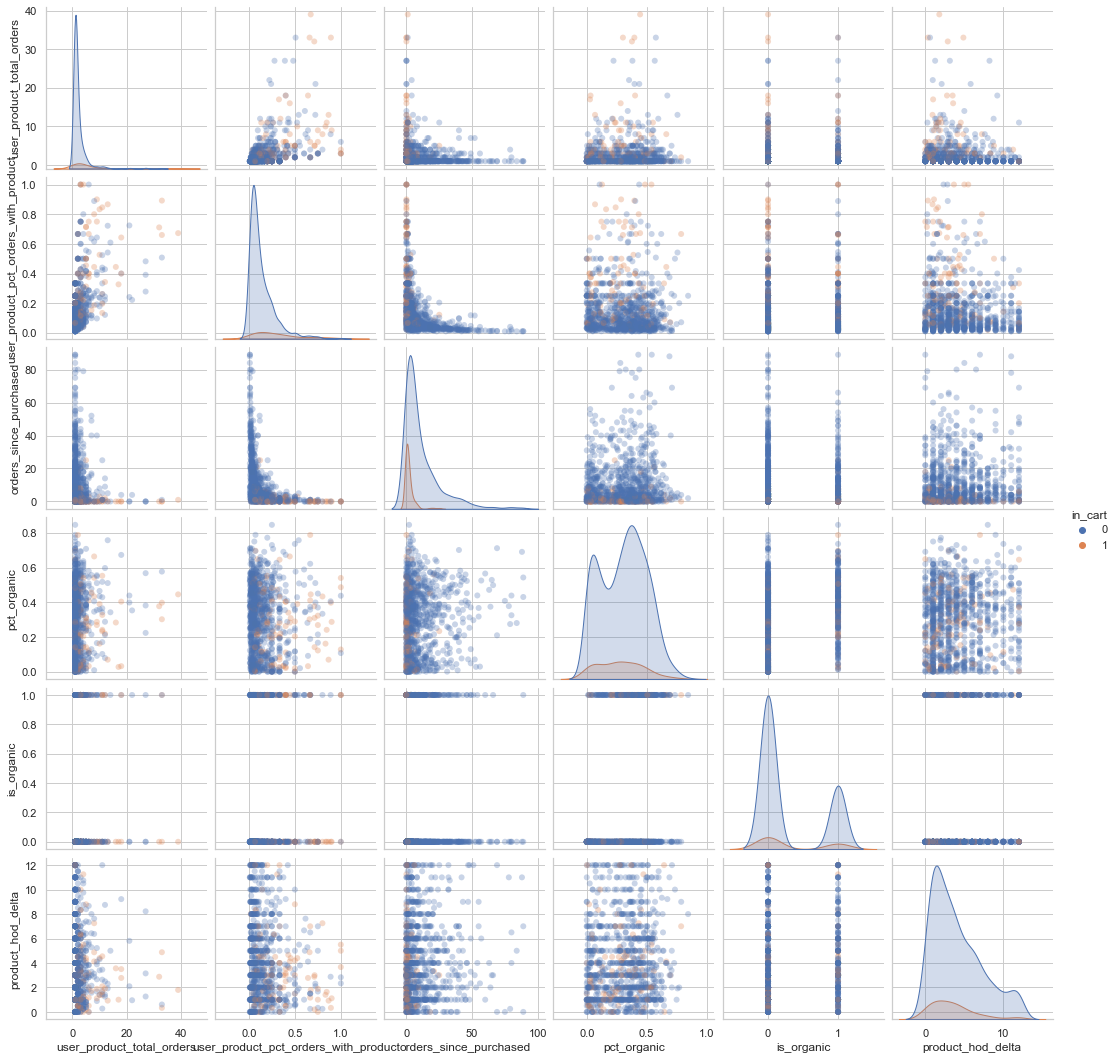

In [30]:
plot_features(df_X)

F1 Score: 0.35596 

Confusion Matrix: 
 [[0.66965028 0.2301818 ]
 [0.02864256 0.07152535]] 

ROC AUC score =  0.8096


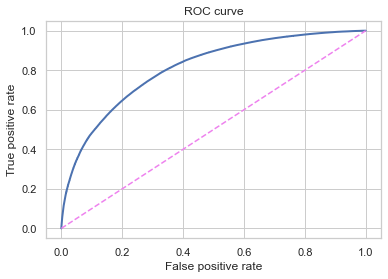

In [31]:
X_tr, X_val, X_te, y_tr, y_val, y_te = get_user_split_data(df_X)
X_train_scaled, X_val_scaled, lr = run_logreg(X_tr, X_val, y_tr, y_val)

Threshold of 0.699:
Precision: 0.4007,   Recall: 0.4007
F1 score:  0.40074070449729576


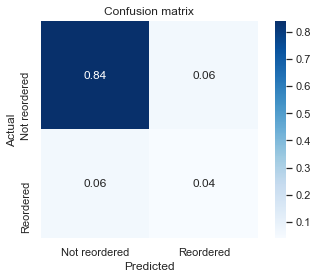

In [32]:
best_thresh = find_best_thresh(lr, X_val_scaled, y_val)
find_f1(lr, X_val_scaled, y_val, best_thresh)

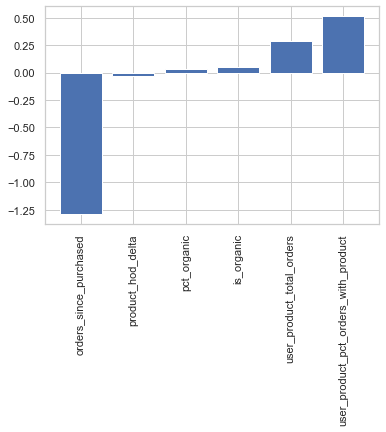

In [33]:
df_features = df_X.columns.drop(['product_id','user_id','latest_cart', 'in_cart']) 

D = dict(zip(df_features, lr.coef_.T.flatten()))
D = {k: v for k, v in sorted(D.items(), key=lambda item: item[1])}
#plt.figure(figsize=(15, 10))
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.xticks(rotation=90);

## Random Forest Classifier

In [34]:
# Random Forest: 
X_tr, X_val, X_te, y_tr, y_val, y_te = get_user_split_data(df_X)

rfc = RandomForestClassifier(n_estimators=10, max_depth=10, class_weight='balanced')
rfc.fit(X_tr, y_tr)
rfc.score(X_val, y_val)

0.7392333079232086

F1 Score: 0.3630047667813543 

Confusion Matrix: 
 [[0.66493169 0.23490039]
 [0.0258663  0.07430162]] 

ROC AUC score =  0.8186216293293184


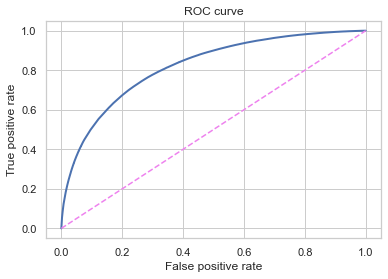

In [35]:
preds = rfc.predict(X_val)
print('F1 Score:', f1_score(preds, y_val), '\n')

# Print confusion matrix for random forest
rfc_confusion = confusion_matrix(y_val, preds, normalize='all')
print('Confusion Matrix: \n', rfc_confusion, '\n')

# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 
fpr, tpr, thresholds = roc_curve(y_val, rfc.predict_proba(X_val)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_val, rfc.predict_proba(X_val)[:,1]))

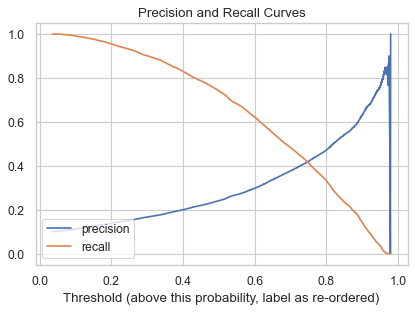

In [43]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, rfc.predict_proba(X_val)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as re-ordered)');
plt.title('Precision and Recall Curves');

In [48]:
# identify the optimal threshold? 
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, rfc.predict_proba(X_val)[:,1] )

idx = np.argmin(np.abs(precision_curve[:-7] - recall_curve[:-7]))
best_threshold = threshold_curve[idx]
best_threshold

# using the new best threshold
y_predict = (rfc.predict_proba(X_val)[:,1] > best_threshold)
print(f"Threshold of {best_threshold:.2f}:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))
print('F1 score: ', f1_score(y_predict, y_val))

Threshold of 0.75:
Precision: 0.4169,   Recall: 0.4169
F1 score:  0.4169370318792578


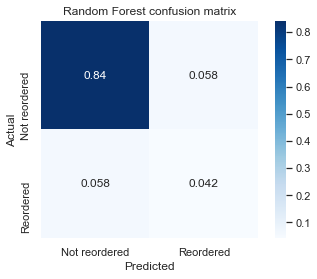

In [49]:
# Print confusion matrix for random_forest
rfc_confusion = confusion_matrix(y_val, y_predict, normalize='all')
sns.heatmap(rfc_confusion, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=['Not reordered', 'Reordered'],
           yticklabels=['Not reordered', 'Reordered'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest confusion matrix');

plt.savefig("confusion_matrix_rfc_instacart")

In [38]:
#F1 TO BEAT 0.413

In [39]:
df_features = df_X.columns.drop(['product_id','user_id','latest_cart', 'in_cart']) 
df_features

Index(['user_product_total_orders', 'user_product_pct_orders_with_product',
       'orders_since_purchased', 'pct_organic', 'is_organic',
       'product_hod_delta'],
      dtype='object')

In [40]:
rfc.feature_importances_ 

array([0.13468059, 0.24096247, 0.60990887, 0.0054866 , 0.00251799,
       0.00644347])

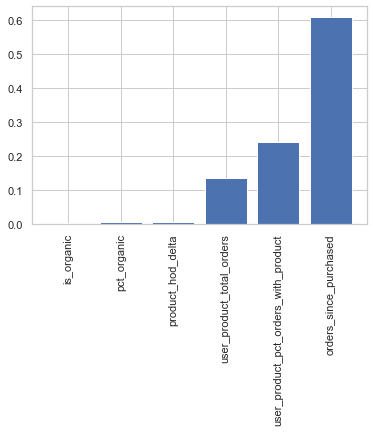

In [41]:
D = dict(zip(df_features, rfc.feature_importances_ ))
D = {k: v for k, v in sorted(D.items(), key=lambda item: item[1])}
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.xticks(rotation=90);

# Testing our Final Model on Holdout Set

In [51]:
# using the new best threshold
y_predict = (rfc.predict_proba(X_te)[:,1] > best_threshold)
print(f"Threshold of {best_threshold:.2f}:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_te, y_predict), 
                                                     recall_score(y_te, y_predict)))
print('F1 score: ', f1_score(y_predict, y_te))

Threshold of 0.75:
Precision: 0.4179,   Recall: 0.4162
F1 score:  0.4170480100807303


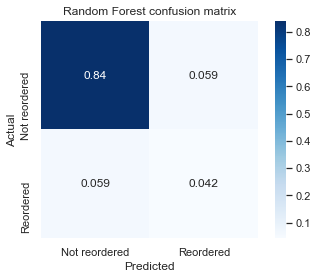

In [52]:
# Print confusion matrix for random_forest
rfc_confusion = confusion_matrix(y_te, y_predict, normalize='all')
sns.heatmap(rfc_confusion, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=['Not reordered', 'Reordered'],
           yticklabels=['Not reordered', 'Reordered'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest confusion matrix');

plt.savefig("confusion_matrix_rfc_instacart")

## Next Steps:

#### Engineer more meaningful features:

So far the way we've used the order history treats the entire history on equal terms - for example, user-product order frequency treats orders from months ago the same as recent ones. Come up with features that focus more on the most recent orders or give them more weight than older ones.

Other ideas include adding another user-product feature that computes the % of times a product shows up consecutively in the user's orders (i.e. they reordered it immediately in the next order).

Add product category / aisle information as categorical features.

#### Experiment with different class weights. 

#### Try more sophisticated models:
- XGboost
- Gradient Boosting Machines 

#### Extend functionality:

Recommend recipes to users that align with their purchasing patterns. Possible inspirations: [here](https://www.kaggle.com/kaggle/recipe-ingredients-dataset/home) and [here](https://www.geeksforgeeks.org/convert-json-to-csv-in-python/).

#### Reduce memory usage.
